<img src='./img/c3s_header.png' align='right' width='100%'></img>

<br>

# CMIP6: Global climate projections

### About

This notebook provides you a practical introduction to [CMIP6 global climate projections](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview). The workflow introduces you to four different experiments of the CMIP6 Global climate projections: `historical`, `SSP1-2.6`, `SSP2-4.5`, `SSP5-8.5`. The workflow shows you how to compute and visualize the annual global average temperature from 1850 to 2100. You will use the `historical` experiment for the temporal period 1850 to 2014 and the three scenarios `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` for the period from 2015 to 2100. 

The example showcases data from the Global Climate model `HadGEM3-GC31-LL` by the Met Office Hadley Centre. See [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Models,gridsandpressurelevels) a full list of models included in the CDS-CMIP6 subset.


In general, CMIP6 experiments can be divided in two main categories:

**Historical**: Historical experiments cover the period where modern climate observations exist. These experiements show how the Global Circulation Model (GCM) perform for the past climate and can be used as reference period for comparison with scenario runs for the future. The period for the `historical` experiment is 1850-2014. 

**Projections for the future**: the climate projection experiments for the future climate follow the SSP scenarios, which can be decomposed into two pathways, a `Shared Socioeconomic Pathway (SSP)` and a `Representative Concentration Pathway (RCP)`. The two pathways are represented by the three digits that are part of the experiment's name. The first digit represent the SSP storyline for the socio-economic mitigation and adaptation challenges that the experiment represents. The second and third digit represent the RCP climate forcing that the experiment follows.
* **SSP1-2.6**: SSP1-2.6 is based on SSP1 with low climate change mitigation and adaptation challenges and RCP2.6, a future pathway with a radiative forcing of 2.6 W/m2 in the year 2100. The SSP1-2.6 scenario represents the `low end of plausible future forcing pathways`. SSP1-2.6 depicts a "best case" future from a sustainability perspective.
* **SSP2-4.5**: SSP2-4.5 is based on SSP2 with intermediate climate change mitigation and adaptation challenges and RCP4.5, a future pathway with a radiative forcing of 4.5 W/m2 in the year 2100. The ssp245 scenario represents the `medium part of plausible future forcing pathways`. SSP2-4.5 is comparable to the CMIP5 experiment RCP4.5.
* **SSP5-8.5**: SSP5-8.5 is based on SSP5 in which climate change mitigation challenges dominate and RCP8.5, a future pathway with a radiative forcing of 8.5 W/m2 in the year 2100. The ssp585 scenario represents the `high end of plausible future forcing pathways`.  SSP5-8.5 is comparable to the CMIP5 experiment RCP8.5.

Learn [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Experiments) more about CMIP6 experiments in the Copernicus Climate Data Store.


The notebook has the following outline:

* [1 - Request data from the CDS programmatically with the CDS API](#request_data_cmip6)
* [2 - Unzip the downloaded data files](#unzip)
* [3 - Load and prepare CMIP6 historical data](#load_prepare_historical)
* [4 - Load and prepare CMIP6 Shared Socioeconomic Pathway (SSP) scenarios](#load_prepare_ssp)
* [5 - Visualize CMIP6 annual global average temperature from 1850 to 2100](#visualize_cmip6)

### Data

This notebook introduces you to [CMIP6 Global climate projections](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview). The four datasets used in the notebook have the following specifications:

> **Data**: `CMIP6 Global climate projections - Experiment: Historical` <br>
> **Temporal coverage**: `Feb 1850 to Dec 2014` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zip`


> **Data**: `CMIP6 Global climate projections - Experiment: SSP1-2.6` <br>
> **Temporal coverage**: `Jan 2015 - Dec 2100` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zip`


> **Data**: `CMIP6 Global climate projections - Experiment: SSP2-4.5` <br>
> **Temporal coverage**: `Jan 2015 - Dec 2100` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zip`


> **Data**: `CMIP6 Global climate projections - Experiment: SSP5-8.5` <br>
> **Temporal coverage**: `Jan 2015 - Dec 2100` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zip`


### How to access the notebook
* [**nbviewer**](https://nbviewer.org/github/ecmwf-projects/copernicus-training/blob/master/131_c3s_global_climate_projections.ipynb)
* [**Colab**](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/131_c3s_global_climate_projections.ipynb)
* [**Binder**](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/131_c3s_global_climate_projections.ipynb)
* [**Kaggle**](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/131_c3s_global_climate_projections.ipynb)

<hr>

### Install CDS API via pip

In [ ]:
!pip install cdsapi

### Load libraries

In [8]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature


<hr>

## <a id='request_data_cmip6'></a> 1. Request data from the CDS programmatically with the CDS API

The first step is to request data from the Climate Data Store programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal CDS key. Please find [here](https://cds.climate.copernicus.eu/api-how-to) your personal CDS key.

In [44]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'

<br>

The next step is then to request the data with the help of the CDS API. Below, we run four data requests:
* **Historical experiment**: Monthly aggregated historical near surface air temperature from 1850 to 2014.
* **SSP1-2.6**: Monthly aggregated projection (2015 to 2100) of near surface air temperature - SSP1-2.6 experiment
* **SSP2-4.5**: Monthly aggregated projection (2015 to 2100) of near surface air temperature - SSP2-4.5 experiment
* **SSP5-8.5**: Monthly aggregated projection (2015 to 2100) of near surface air temperature - SSP5-8.5 experiment

CMIP6 data are disseminated as netcdf files within a zip archive.

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

# Historical experiment
c.retrieve(
    'projections-cmip6',
    {
        'format': 'zip',
        'temporal_resolution': 'monthly',
        'experiment': 'historical',
        'level': 'single_levels',
        'variable': 'near_surface_air_temperature',
        'model': 'hadgem3_gc31_ll',
        'date': '1850-02-01/2014-12-31',
    },
    './1850-2014_historical_monthly.zip')

# Experiment: SSP1-2.6
c.retrieve(
    'projections-cmip6',
    {
        'format': 'zip',
        'temporal_resolution': 'monthly',
        'experiment': 'ssp1_2_6',
        'level': 'single_levels',
        'variable': 'near_surface_air_temperature',
        'model': 'hadgem3_gc31_ll',
        'date': '2015-01-01/2100-12-31',
    },
    './2015-2100_ssp1_2_6_monthly.zip')

# Experiment: SSP2-4.5
c.retrieve(
    'projections-cmip6',
    {
        'format': 'zip',
        'temporal_resolution': 'monthly',
        'experiment': 'ssp2_4_5',
        'level': 'single_levels',
        'variable': 'near_surface_air_temperature',
        'model': 'hadgem3_gc31_ll',
        'date': '2015-01-01/2100-12-31',
    },
    './2015-2100_ssp2_4_5_monthly.zip')

# Experiment: SSP5-8.5
c.retrieve(
    'projections-cmip6',
    {
        'format': 'zip',
        'temporal_resolution': 'monthly',
        'experiment': 'ssp5_8_5',
        'level': 'single_levels',
        'variable': 'near_surface_air_temperature',
        'model': 'hadgem3_gc31_ll',
        'date': '2015-01-01/2100-12-31',
    },
    './2015-2100_ssp5_8_5_monthly.zip')

<br>

## <a id='unzip'></a>2. Unzip the downloaded data files

From the Copernicus Climate Data Store, CMIP6 data are available as `zip` archive. For this reason, before we can load any data, we have to unzip the zip files. Once you downloaded the four experiments `historical`, `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` as seperate zip files, you can use the functions from the `zipfile` Python package to extract the content of a zip file. First, you construct a `ZipFile()` object and second, you apply the function `extractall()` to extract the content of the zip file.

Below, the same process is repeated for all four zip files. You see that the actual data files are disseminated in `NetCDF`. One file was extracted for the historical experiment and two files for each of the scenarios.

In [6]:
import zipfile
with zipfile.ZipFile('./1850-2014_historical_monthly.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [10]:
import zipfile
with zipfile.ZipFile('./2015-2100_ssp1_2_6_monthly.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [11]:
import zipfile
with zipfile.ZipFile('./2015-2100_ssp2_4_5_monthly.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [12]:
import zipfile
with zipfile.ZipFile('./2015-2100_ssp5_8_5_monthly.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

<br>

## <a id='load_prepare_historical'></a>3. Load and prepare CMIP6 historical data

The subsequent example will show you how to prepare CMIP6 data to create a graph of annual global average temperature combining four experiments. The first step is to load and prepare the CMIP6 data of the `historical` experiment. `Historical` experiments can be used as a reference period for comparison with scenario runs for the future. The period covered is typcially 1850 to 2014. The historical data from the `HadGEM3-GC31-LL` are available until December 2014.

The first step is to load the data of the `historical` experiment and aggregate the data in space and time to create a list of annual global average temperature for each year from 1850 to 2014.

CMIP6 data, once unzipped, are disseminated in `NetCDF`. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read NetCDF files.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `lat`, `lon`, `time`, of which the dimension `bnds` is not callable.

In [9]:
ds_historical = xr.open_dataset('./tas_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500216-20141216_v20190624.nc')
ds_historical

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 1979)
Coordinates:
  * time       (time) object 1850-02-16 00:00:00 ... 2014-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-06-19T11:21:17Z
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b6959414-d5ed-4cd9-a627-59238e52132d

Above, you see that the `xarray.Dataset()` consists of four data variables. The variable of interest is `tas`. By adding the name of a variable in square brackets, you can load the variable from a Dataset. The resulting object is a `xarray.DataArray()`. The data array has three dimensions and provides under `Attributes` more information about the data, e.g. `long_name` or `units`. 

In [13]:
tas_historical = ds_historical['tas']
tas_historical

<xarray.DataArray 'tas' (time: 1979, lat: 144, lon: 192)>
[54715392 values with dtype=float32]
Coordinates:
  * time     (time) object 1850-02-16 00:00:00 ... 2014-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-06-19T11:21:17Z altered by CMOR: Treated scalar dime...

An inspection of the `time` dimension shows that the data are monthly aggregates for each month from February 1850 to December 2014.

In [14]:
tas_historical.time

<xarray.DataArray 'time' (time: 1979)>
array([cftime.Datetime360Day(1850, 2, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.Datetime360Day(1850, 3, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.Datetime360Day(1850, 4, 16, 0, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.Datetime360Day(2014, 10, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.Datetime360Day(2014, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.Datetime360Day(2014, 12, 16, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-02-16 00:00:00 ... 2014-12-16 00:00:00
    height   float64 1.5
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

An inspection of the dimensions `lat` and `lon` shows that the data have a resolution of 1.25 degrees for latitudes and 1.875 degrees for longitudes.

In [15]:
tas_historical.lat, tas_historical.lon

(<xarray.DataArray 'lat' (lat: 144)>
 array([-89.375, -88.125, -86.875, -85.625, -84.375, -83.125, -81.875, -80.625,
        -79.375, -78.125, -76.875, -75.625, -74.375, -73.125, -71.875, -70.625,
        -69.375, -68.125, -66.875, -65.625, -64.375, -63.125, -61.875, -60.625,
        -59.375, -58.125, -56.875, -55.625, -54.375, -53.125, -51.875, -50.625,
        -49.375, -48.125, -46.875, -45.625, -44.375, -43.125, -41.875, -40.625,
        -39.375, -38.125, -36.875, -35.625, -34.375, -33.125, -31.875, -30.625,
        -29.375, -28.125, -26.875, -25.625, -24.375, -23.125, -21.875, -20.625,
        -19.375, -18.125, -16.875, -15.625, -14.375, -13.125, -11.875, -10.625,
         -9.375,  -8.125,  -6.875,  -5.625,  -4.375,  -3.125,  -1.875,  -0.625,
          0.625,   1.875,   3.125,   4.375,   5.625,   6.875,   8.125,   9.375,
         10.625,  11.875,  13.125,  14.375,  15.625,  16.875,  18.125,  19.375,
         20.625,  21.875,  23.125,  24.375,  25.625,  26.875,  28.125,  29.375,
   

<br>

The next step is to aggregate the temperature values spatially and compute the global monthly near-surface temperature. 
To do this, the first step is to compute an overall weighted mean for the global near-surface air temperature for the reference period. You can compute the overall weighted mean of the data array object `tas_historical_global` in two steps:
1. `Calculating the weights`: for a regular latitude/longitude grid, the cosine of the latitude can be used as proxy for the grid cell area.
2. `Creating the average over latitude and longitude dimensions`: by applying the function `mean()` to the two dimensions `['longitude', 'latitude]`, we can compute the weighted global air temperature. 

In [20]:
weights = np.cos(np.deg2rad(tas_historical.lat))
weights.name = "weights"

tas_historical_weighted = tas_historical.weighted(weights)
tas_historical_weighted

DataArrayWeighted with weights along dimensions: lat

The second step is then to compute the mean across the latitude and longitude dimensions of the weighted data array (`tas_historical_weighted`) with the function `mean()`. The result is a DataArray with one dimension (`time`) and 1979 entries. Please note, this operations leads to a drop of all attribute information.

In [22]:
tas_historical_global = tas_historical_weighted.mean(['lat', 'lon'])
tas_historical_global

<xarray.DataArray 'tas' (time: 1979)>
array([284.67121777, 285.34055927, 286.48285542, ..., 288.27214291,
       287.16432839, 286.22094815])
Coordinates:
  * time     (time) object 1850-02-16 00:00:00 ... 2014-12-16 00:00:00
    height   float64 1.5

The next step is then to aggregate the monthly global near-surface air temperature values to annual global near-surface air temperature values. This operation can be done in two steps: first, all the values for one specific year have to be grouped with the function `groupby()` and second, you can create the average of each group with the function `mean()`.

The result is a one-dimensional DataArray with 165 entries. Please note that this operation changes the name of the dimension from `time` to `year`.

In [23]:
tas_historical_y1 = tas_historical_global.groupby('time.year').mean()
tas_historical_y1

<xarray.DataArray 'tas' (year: 165)>
array([286.90399058, 286.76972281, 286.84983418, 286.73121524,
       286.57119522, 286.80739828, 286.91131597, 286.88791802,
       286.80716427, 286.82835953, 286.8458831 , 286.77055952,
       286.70175635, 286.76000565, 286.88843491, 286.97236892,
       286.96097131, 286.86154059, 286.71211982, 286.74462567,
       286.84838333, 286.86297368, 286.776492  , 286.62792634,
       286.59426972, 286.72834863, 286.79239096, 286.7423281 ,
       286.73969398, 286.74995504, 286.8284006 , 286.73594713,
       286.67578675, 286.70900851, 286.48312269, 286.49003796,
       286.59220428, 286.6184809 , 286.682143  , 286.67096238,
       286.71463006, 286.75706616, 286.60990259, 286.67832378,
       286.78428028, 286.6534919 , 286.78096095, 286.8218442 ,
       286.74183465, 286.74545236, 286.72329724, 286.75939761,
       286.62178509, 286.45891415, 286.64458141, 286.60830435,
       286.64019517, 286.7430144 , 286.58560995, 286.41435911,
       286.43967819, 286.58989207, 286.52834352, 286.64492732,
       286.73852128, 286.70871324, 286.65181185, 286.67223888,
       286.76381449, 286.89087832, 286.8119678 , 286.78366253,
       286.76540165, 286.8649855 , 286.89137372, 286.79107948,
       286.85797182, 286.79631935, 286.88509469, 286.80373661,
...
       286.82134228, 286.83391298, 286.87435359, 286.99893734,
       286.8050208 , 286.64563556, 286.72712205, 286.66146538,
       286.78706029, 286.84014757, 286.74581395, 286.88335949,
       286.69862598, 286.7105221 , 286.83488988, 287.00543033,
       286.84537643, 286.71374873, 286.88657224, 286.90782355,
       286.82365289, 286.8363859 , 286.88715096, 286.86583257,
       286.75145055, 286.53767846, 286.51111532, 286.46862699,
       286.52891252, 286.59299901, 286.73245819, 286.80571038,
       286.6513954 , 286.72108684, 286.82658109, 286.84014918,
       286.73563181, 286.68943906, 286.56977666, 286.74343387,
       286.67095971, 286.73080402, 286.74721711, 286.62423691,
       286.7265511 , 286.62926237, 286.81280077, 286.7327788 ,
       286.80053053, 286.8071354 , 286.79174053, 286.96142564,
       287.07498136, 287.09247595, 286.86900547, 286.78782205,
       286.80966444, 286.9239971 , 287.01611983, 287.07502511,
       287.08797987, 287.08576601, 287.20780187, 287.44723208,
       287.47948257, 287.44396489, 287.54388652, 287.55348727,
       287.73702302, 287.61641564, 287.56776595, 287.60639529,
       287.79556188, 287.95767649, 287.87083466, 287.85964046,
       287.97903285])
Coordinates:
    height   float64 1.5
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014

As a last step, let us convert the near-surface air temperature values from Kelvin to degrees Celsius. You can simply do this by subtracting 273.15 from the temperature values in Kelvin. 

In [24]:
tas_historical_y1 = tas_historical_y1 - 273.15
tas_historical_y1

<xarray.DataArray 'tas' (year: 165)>
array([13.75399058, 13.61972281, 13.69983418, 13.58121524, 13.42119522,
       13.65739828, 13.76131597, 13.73791802, 13.65716427, 13.67835953,
       13.6958831 , 13.62055952, 13.55175635, 13.61000565, 13.73843491,
       13.82236892, 13.81097131, 13.71154059, 13.56211982, 13.59462567,
       13.69838333, 13.71297368, 13.626492  , 13.47792634, 13.44426972,
       13.57834863, 13.64239096, 13.5923281 , 13.58969398, 13.59995504,
       13.6784006 , 13.58594713, 13.52578675, 13.55900851, 13.33312269,
       13.34003796, 13.44220428, 13.4684809 , 13.532143  , 13.52096238,
       13.56463006, 13.60706616, 13.45990259, 13.52832378, 13.63428028,
       13.5034919 , 13.63096095, 13.6718442 , 13.59183465, 13.59545236,
       13.57329724, 13.60939761, 13.47178509, 13.30891415, 13.49458141,
       13.45830435, 13.49019517, 13.5930144 , 13.43560995, 13.26435911,
       13.28967819, 13.43989207, 13.37834352, 13.49492732, 13.58852128,
       13.55871324, 13.50181185, 13.52223888, 13.61381449, 13.74087832,
       13.6619678 , 13.63366253, 13.61540165, 13.7149855 , 13.74137372,
       13.64107948, 13.70797182, 13.64631935, 13.73509469, 13.65373661,
       13.50726181, 13.442404  , 13.51578823, 13.49988313, 13.58586453,
       13.72074743, 13.50039503, 13.5595421 , 13.67134228, 13.68391298,
       13.72435359, 13.84893734, 13.6550208 , 13.49563556, 13.57712205,
       13.51146538, 13.63706029, 13.69014757, 13.59581395, 13.73335949,
       13.54862598, 13.5605221 , 13.68488988, 13.85543033, 13.69537643,
       13.56374873, 13.73657224, 13.75782355, 13.67365289, 13.6863859 ,
       13.73715096, 13.71583257, 13.60145055, 13.38767846, 13.36111532,
       13.31862699, 13.37891252, 13.44299901, 13.58245819, 13.65571038,
       13.5013954 , 13.57108684, 13.67658109, 13.69014918, 13.58563181,
       13.53943906, 13.41977666, 13.59343387, 13.52095971, 13.58080402,
       13.59721711, 13.47423691, 13.5765511 , 13.47926237, 13.66280077,
       13.5827788 , 13.65053053, 13.6571354 , 13.64174053, 13.81142564,
       13.92498136, 13.94247595, 13.71900547, 13.63782205, 13.65966444,
       13.7739971 , 13.86611983, 13.92502511, 13.93797987, 13.93576601,
       14.05780187, 14.29723208, 14.32948257, 14.29396489, 14.39388652,
       14.40348727, 14.58702302, 14.46641564, 14.41776595, 14.45639529,
       14.64556188, 14.80767649, 14.72083466, 14.70964046, 14.82903285])
Coordinates:
    height   float64 1.5
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014

Now, the historical near-surface air temperature are in a format for our needs and we can continue loading and preparing the three scenario datasets.

<br>

## <a id='load_prepare_ssp'></a> 4. Load and prepare CMIP6 Shared Socioeconomic Pathway (SSP) scenarios

Now, we can load the files with the `CMIP6 Shared Socioeconomic Pathway (SSP) scenarios` and prepare it in the same way as we prepared the `historical` experiment data. The zip files of the scenarios contain two `NetCDF` files: one for the time period from Jan 2015 to Dec 2049 and one for the time period from 1 Jan 2050 to Dec 2100. You can open multiple `NetCDF` files with the xarray function `open_mfdataset()`. The function concatenates multiple files on common dimensions. The CMIP6 scenario files are concatenated on the dimension `time`.

You can open the data files for each of the three scenarios. The result is three xarray.Datasets, which have the same structure as the dataset of the historical experiment: four dimensions, but only three are callable: `lat`, `lon` and `time`. The time dimension has 1032 entries, which are monthly entries for 86 years. The spatial resolution is the same as for the historical experiment; 1.25 degrees for latitudes and 1.875 for longitudes.

In [25]:
ds_ssp126 = xr.open_mfdataset('./*ssp126*.nc')
ds_ssp245 = xr.open_mfdataset('./*ssp245*.nc')
ds_ssp585 = xr.open_mfdataset('./*ssp585*.nc')

ds_ssp126

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 1032)
Coordinates:
  * time       (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 1.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(420, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(420, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(420, 192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(420, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    creation_date:          2020-01-13T10:05:17Z
    ...                     ...
    variable_id:            tas
    variable_name:          tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b0278ac1-c92e-4847-9dc8-e75cbb8f30af

Now we load the data variable `tas` from the Datasets above. You can load a data variable from a Dataset by adding the name of the variable in square brackets.

In [26]:
tas_ssp126 = ds_ssp126['tas']
tas_ssp245 = ds_ssp245['tas']
tas_ssp585 = ds_ssp585['tas']

tas_ssp126

<xarray.DataArray 'tas' (time: 1032, lat: 144, lon: 192)>
dask.array<concatenate, shape=(1032, 144, 192), dtype=float32, chunksize=(612, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-01-13T10:05:17Z altered by CMOR: Treated scalar dime...

<br>

In a next step, we spatially aggregate the global fields in order to create the global monthly near-surface air temperature. To do this, the first step is to compute an overall weighted mean for the global near-surface air temperature for projection period. You can compute the overall weighted mean of the data arrays in two steps:
1. `Calculating the weights`: for a regular latitude/longitude grid, the cosine of the latitude can be used as proxy for the grid cell area.
2. `Creating the average over latitude and longitude dimensions`: by applying the function `mean()` to the two dimensions `['lon', 'lat']`, we can compute the weighted global air temperature. 

First, for each of the projections, we calculate the weights by using the cosine of the latitude as proxy for the grid cell area. In a second step, we then apply the weights to the data arrays with the xarray function `weighted()`.

In [27]:
weights_ssp126 = np.cos(np.deg2rad(tas_ssp126.lat))
weights_ssp126.name = "weights"
tas_ssp126_weighted = tas_ssp126.weighted(weights_ssp126)

weights_ssp245 = np.cos(np.deg2rad(tas_ssp245.lat))
weights_ssp245.name = "weights"
tas_ssp245_weighted = tas_ssp245.weighted(weights_ssp245)

weights_ssp585 = np.cos(np.deg2rad(tas_ssp585.lat))
weights_ssp585.name = "weights"
tas_ssp585_weighted = tas_ssp585.weighted(weights_ssp585)


tas_ssp585_weighted

DataArrayWeighted with weights along dimensions: lat

The second step is then to compute the mean across the latitude and longitude dimensions of the weighted data arrays with the function `mean()`. The resulting data arrays have only one dimension left: `time`. Note that this operation causes a drop of all the data array attributes.

In [28]:
tas_ssp126_global = tas_ssp126_weighted.mean(['lat', 'lon'])
tas_ssp245_global = tas_ssp245_weighted.mean(['lat', 'lon'])
tas_ssp585_global = tas_ssp585_weighted.mean(['lat', 'lon'])
tas_ssp126_global

<xarray.DataArray 'tas' (time: 1032)>
dask.array<truediv, shape=(1032,), dtype=float64, chunksize=(612,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
    height   float64 1.5

Further, we want to aggregate the global monthly near-surface air temperature values to global near-surface air temperature values per year. This aggregation can be done in two steps: first, all the values for one specific year have to be grouped with the function `groupby()` and second, you can create the average of each group with the function `mean()`.

The result is a one-dimensional DataArray with 86 entries. Please note that this operation changes the name of the `time` dimension to `year`.

In [32]:
tas_ssp126_y1 = tas_ssp126_global.groupby('time.year').mean()
tas_ssp245_y1 = tas_ssp245_global.groupby('time.year').mean()
tas_ssp585_y1 = tas_ssp585_global.groupby('time.year').mean()

tas_ssp126_y1

<xarray.DataArray 'tas' (year: 86)>
dask.array<stack, shape=(86,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 1.5
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

<br>

The last step is to convert the near-surface air temperature values from Kelvin to degrees Celsius by subtracting 273.15. The result are three data arrays, each with 86 entries representing the global annual near-surface air temperature for the time period 2015 to 2100.

In [33]:
tas_ssp126_y1 = tas_ssp126_y1 - 273.15
tas_ssp245_y1 = tas_ssp245_y1 - 273.15
tas_ssp585_y1 = tas_ssp585_y1 - 273.15

tas_ssp126_y1.values, tas_ssp245_y1.values, tas_ssp585_y1.values

(array([14.88600086, 14.92868049, 14.95678421, 15.18717962, 15.02731645,
        15.11225657, 15.05664765, 15.1636196 , 15.20146191, 15.06597938,
        15.24372815, 15.32997264, 15.44931662, 15.44825559, 15.31210343,
        15.38173369, 15.43352537, 15.47558988, 15.41215846, 15.58622712,
        15.70297051, 15.6415391 , 15.61168268, 15.58343176, 15.78728886,
        15.65811758, 15.57230434, 15.66089062, 15.6980594 , 15.76306508,
        15.69016193, 15.71906987, 15.85223222, 15.88195635, 15.87553682,
        15.78492278, 16.06330091, 16.02631776, 15.83338654, 15.98742266,
        16.01472542, 15.88863905, 15.87943174, 16.07992611, 16.07022482,
        15.94804714, 16.02138011, 16.05440668, 16.12334339, 16.10511683,
        16.0736693 , 16.15777069, 15.97498471, 16.20202269, 16.37564834,
        16.17938011, 16.22404458, 16.23894361, 16.33503487, 16.2458322 ,
        16.32932359, 16.41940541, 16.45334557, 16.17768377, 16.07776739,
        16.28338458, 16.47187663, 16.35057407, 16.2

<br>

## <a id='visualize_cmip6'></a>5. Visualize the CMIP6 annual global average temperature from 1850 to 2100

The last step is to visualize the historical experiments together with the three scenarios in one time-series plot. You can use the matplotlib function `plot()` to plot the time-series information. As x-axis, you want to specify the dimension year and as y-axis you want to specify the near-surface air temperature values in degrees Celsius. 

The plotting function below has four main parts:
* **Initiate the plot**: initiate a matplotlib plot with `plt.figure` and `plt.subplot()`
* **Plot the time-series information**: plot the time series information of the historical experiment and three scenarios with the `plot()` function
* **Set axes labels and a title**: Define title and axes labels
* **Set limits for y-axis, add gridlines and legend**: add additional items to the plot, such as legend or gridlines

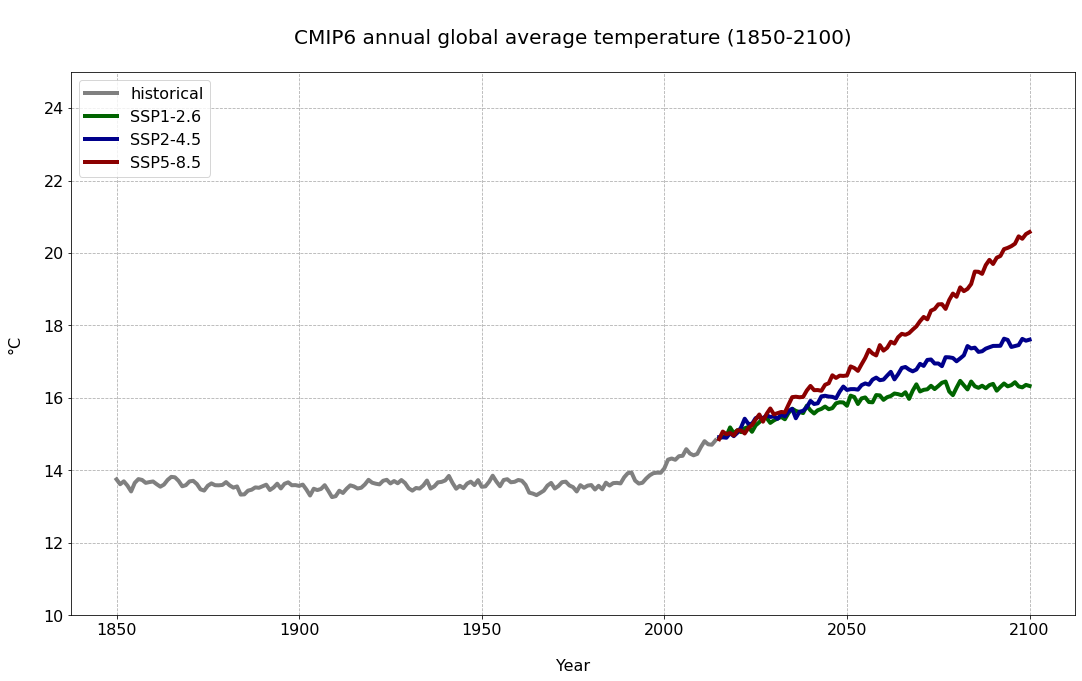

In [37]:
# Initiate the plot
fig = plt.figure(figsize=(18,10))
ax = plt.subplot()

# Plot the global annual near-surface air temperature data for the historical experiment
ax.plot(tas_historical_y1.year[:], tas_historical_y1, color='grey', linewidth='4', label='historical')

# Plot the global annual near-surface air temperature data for the three scenarios
ax.plot(tas_ssp126_y1.year[:], tas_ssp126_y1, color='darkgreen', linewidth='4', label='SSP1-2.6')
ax.plot(tas_ssp245_y1.year[:], tas_ssp245_y1, color='darkblue', linewidth='4', label='SSP2-4.5')
ax.plot(tas_ssp585_y1.year[:], tas_ssp585_y1, color='darkred', linewidth='4', label='SSP5-8.5')

# Set axes labels and a title
ax.set_title('\nCMIP6 annual global average temperature (1850-2100)\n', fontsize=20)
ax.set_ylabel('°C\n', fontsize=16)
ax.set_xlabel('\nYear', fontsize=16)

# Customize limits for y-axis, add gridlines and legend
ax.set_ylim(10,25)
ax.grid(linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc=2)

<br>

The visualization of the `CMIP6 annual global average temperature (1850 to 2100)` above shows that the global average temperature was more or less stable in the pre-industrial phase, but steadily increases since the 1990s. It further shows you that, depending on the SSP scenario, the course and increase of the global annual temperature differs fundamentally. While for the best case `SSP1-2.6` scenario, the global annual temperature could stabilize around 16 degC, for the worst case `SSP5-8.5` scenario, the global annual temperature could increase to above 20 degC.

The last step is now to also calculate the standard deviation of the global near surface air temperature for each year. The standard deviation gives us an estimation of the variability of temperature for each year. Let us calculate the +/- standard deviation first for the historical experiment. From the data array `tas_historical_global`, we first group the values per year with the function `groupby('time.year')`. Based on each group, we can then apply the function `std()`, which computes the standard deviation for each year. 

In a second step, we add and subtract the standard deviation from the time-series representing the historical global average temperature, `tas_historical_y1`.

In [ ]:
sd_historical = tas_historical_global.groupby('time.year').std()

y12 = tas_historical_y1 - sd_historical
y13 = tas_historical_y1 + sd_historical

y12, y13

Let us repeat the same procedure for the three projections. We first calculate the standard deviation for each year and second, we add and subtract the standard deviation from the projected global average temperature time-series.

In [42]:
sd_ssp126 = tas_ssp126_global.groupby('time.year').std()
sd_ssp245 = tas_ssp245_global.groupby('time.year').std()
sd_ssp585 = tas_ssp585_global.groupby('time.year').std()

y22 = tas_ssp126_y1 - sd_ssp126
y23 = tas_ssp126_y1 + sd_ssp126

y32 = tas_ssp245_y1 - sd_ssp245
y33 = tas_ssp245_y1 + sd_ssp245

y42 = tas_ssp585_y1 - sd_ssp585
y43 = tas_ssp585_y1 + sd_ssp585

y22, y23

(<xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100,
 <xarray.DataArray 'tas' (year: 86)>
 dask.array<add, shape=(86,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100)

<br>

A common way to visualize the +/- standard deviation values is to colorize the area between -/+ standard deviation. We use the visualisation code from above and to each time-series we add a colorized area with the function `fill_between()`. The function takes the following keyword arguments:
* **x**: x-values of the time-series
* **y1**: lower bounds of y-values of the time-series (- standard deviation)
* **y2**: lower bounds of y-values of the time-series (+ standard deviation)
* **alpha**: apply a alpha factor to make the color less intense
* **color**: set a color
* **label**: add a label for the legend

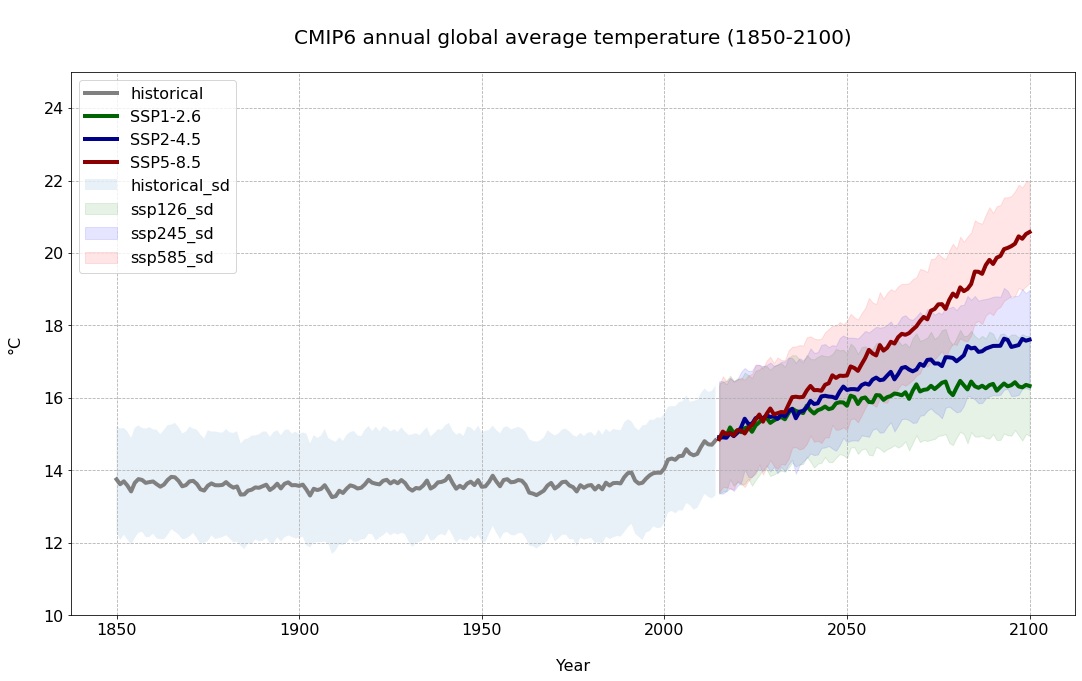

In [43]:
# Initiate the plot
fig = plt.figure(figsize=(18,10))
ax = plt.subplot()

# Plot the global annual near-surface air temperature data for the historical experiment
ax.plot(tas_historical_y1.year[:], tas_historical_y1, color='grey', linewidth='4', label='historical')
ax.fill_between(tas_historical_y1.year[:], y12, y13, alpha=0.1, label='historical_sd')

# Plot the global annual near-surface air temperature data for the three scenarios
ax.plot(tas_ssp126_y1.year[:], tas_ssp126_y1, color='darkgreen', linewidth='4', label='SSP1-2.6')
ax.fill_between(tas_ssp126_y1.year[:], y22, y23, alpha=0.1, color='green', label='ssp126_sd')

ax.plot(tas_ssp245_y1.year[:], tas_ssp245_y1, color='darkblue', linewidth='4', label='SSP2-4.5')
ax.fill_between(tas_ssp245_y1.year[:], y32, y33, alpha=0.1, color='blue', label='ssp245_sd')

ax.plot(tas_ssp585_y1.year[:], tas_ssp585_y1, color='darkred', linewidth='4', label='SSP5-8.5')
ax.fill_between(tas_ssp585_y1.year[:], y42, y43, alpha=0.1, color='red', label='ssp585_sd')

# Set axes labels and a title
ax.set_title('\nCMIP6 annual global average temperature (1850-2100)\n', fontsize=20)
ax.set_ylabel('°C\n', fontsize=16)
ax.set_xlabel('\nYear', fontsize=16)

# Customize limits for y-axis, add gridlines and legend
ax.set_ylim(10,25)
ax.grid(linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc=2)

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>